# Logistic Regression Model on CIFAR10

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import timeit
import seaborn as sns
import pickle
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import os
import random
import optuna # installed with "conda install -c conda-forge optuna"
optuna.logging.set_verbosity(optuna.logging.WARN) # disable INFO logs since we will create a plot
from tqdm import tqdm

import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

set_random_seed(42)

## Downloading the CIFAR10 Dataset

In [4]:
dataset = dsets.CIFAR10(root='data/', download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10(root='data/', train=False, transform=transforms.ToTensor())

Files already downloaded and verified


In [5]:
# We use about 20% of the dataset for validation.
val_size = 10000
train_size = len(dataset) - val_size
batch_size = 128

print("Single Sample Shape: ", dataset[0][0].size())

trainset, valset = random_split(dataset, [train_size, val_size])
print("Data sizes after random splitting -> \nTrain data size = {} \nValidation data size = {} \nTest data size = {}".format(len(trainset),len(valset), len(testset)))

train_loader = DataLoader(trainset, batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size)
test_loader = DataLoader(testset, batch_size)

print("Total number of batches in one epoch (Train):", len(train_loader))
print("Total number of batches in one epoch (Validation):", len(val_loader))
print("Total number of batches in one epoch (Test):", len(test_loader))

Single Sample Shape:  torch.Size([3, 32, 32])
Data sizes after random splitting -> 
Train data size = 40000 
Validation data size = 10000 
Test data size = 10000
Total number of batches in one epoch (Train): 313
Total number of batches in one epoch (Validation): 79
Total number of batches in one epoch (Test): 79


In [6]:
!nvidia-smi

Sun Nov 21 21:21:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8    18W /  N/A |    613MiB / 16102MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


## Model Class

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(LogisticRegression, self).__init__()
        
        self.input_dim = input_dim
        self.out_dim = out_dim

        self.linear1 = nn.Linear(input_dim, out_dim)

    def forward(self, X):
        return self.linear1(X)    

In [9]:
model = LogisticRegression(32*32*3, 10).to(device)
print(model)

LogisticRegression(
  (linear1): Linear(in_features=3072, out_features=10, bias=True)
)


## Training-Evaluation 1

In [10]:
max_epoch = 25
learning_rate = 0.0001
batch_size = 128

model = LogisticRegression(32*32*3, 10).to(device)
train_loader = DataLoader(trainset, batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

history = utils.train_model(model, train_loader, val_loader, optimizer, loss_function, max_epoch, device)

epoch 0 train loss: 2.05038 train acc: 0.28005 val loss: 1.94436 val acc: 0.32634
epoch 1 train loss: 1.90767 train acc: 0.34051 val loss: 1.87853 val acc: 0.35067
epoch 2 train loss: 1.86349 train acc: 0.35655 val loss: 1.84388 val acc: 0.366
epoch 3 train loss: 1.83789 train acc: 0.36826 val loss: 1.83751 val acc: 0.36145
epoch 4 train loss: 1.82171 train acc: 0.37133 val loss: 1.80997 val acc: 0.37866
epoch 5 train loss: 1.80793 train acc: 0.37812 val loss: 1.8084 val acc: 0.37569
epoch 6 train loss: 1.79799 train acc: 0.38092 val loss: 1.79618 val acc: 0.38311
epoch 7 train loss: 1.78944 train acc: 0.38438 val loss: 1.78727 val acc: 0.38558
epoch 8 train loss: 1.78148 train acc: 0.38616 val loss: 1.78087 val acc: 0.38341
epoch 9 train loss: 1.77477 train acc: 0.38848 val loss: 1.77724 val acc: 0.38835
epoch 10 train loss: 1.76944 train acc: 0.39145 val loss: 1.77352 val acc: 0.39181
epoch 11 train loss: 1.76397 train acc: 0.39474 val loss: 1.77874 val acc: 0.38291
epoch 12 train lo

In [11]:
training_loss_hist1, training_acc_hist1, valid_loss_hist1, valid_acc_hist1, weight_grad_norm_hist1, bias_grad_norm_hist1 = history

Test Loss : 1.749049654489831 Test Acc: 0.3863726265822785


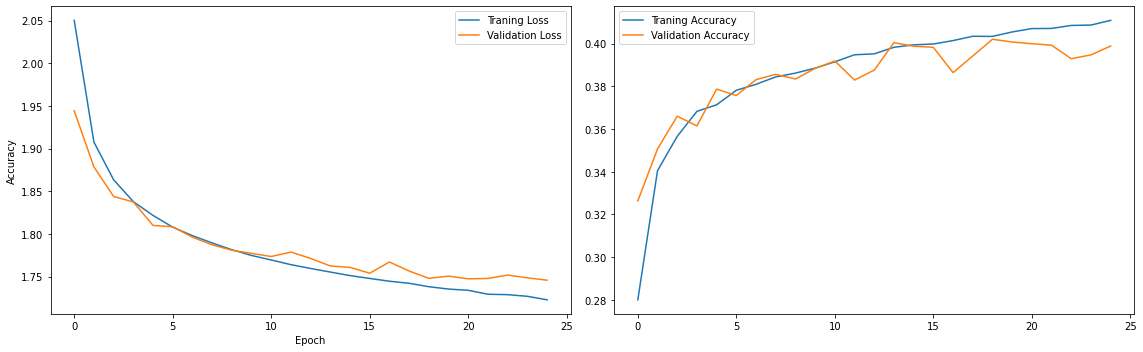

In [12]:
utils.plot_learning_curve(training_loss_hist1, valid_loss_hist1, training_acc_hist1, valid_acc_hist1)

test_loss, test_acc, confusion_matrix1 = utils.evaluate(model, test_loader, loss_function, device=device)
print("Test Loss : {} Test Acc: {}".format(test_loss, test_acc))

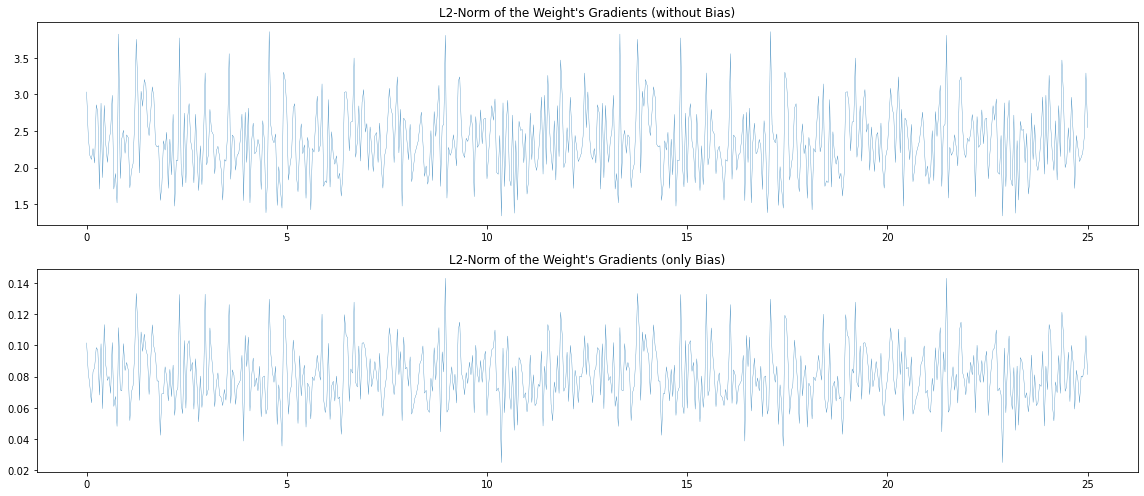

In [13]:
utils.plot_gradient_norms(weight_grad_norm_hist1, bias_grad_norm_hist1, max_epoch)

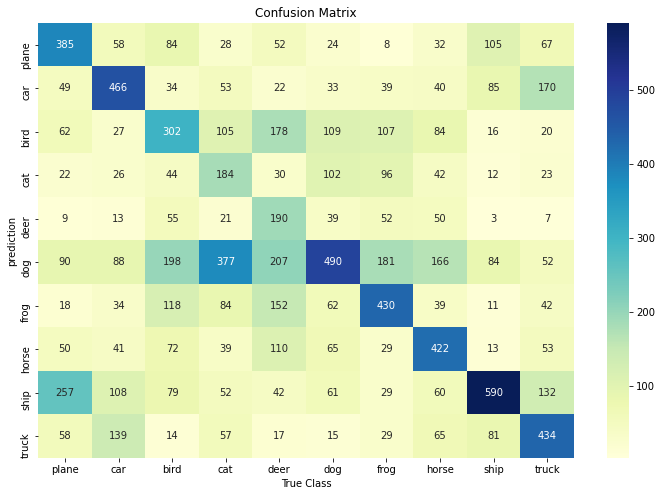

In [14]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
utils.plot_confusion_matrix(confusion_matrix1, classes)

## Training-Evaluation 2

In [15]:
max_epoch = 25
learning_rate = 0.00001
batch_size = 64

model = LogisticRegression(32*32*3, 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
train_loader = DataLoader(trainset, batch_size, shuffle=True)

In [16]:
max_epoch = 25
learning_rate = 0.0001
batch_size = 128

model = LogisticRegression(32*32*3, 10).to(device)
train_loader = DataLoader(trainset, batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

history = utils.train_model(model, train_loader, val_loader, optimizer, loss_function, max_epoch, device)

epoch 0 train loss: 2.05944 train acc: 0.27052 val loss: 1.9534 val acc: 0.33515
epoch 1 train loss: 1.91111 train acc: 0.34021 val loss: 1.87947 val acc: 0.3573
epoch 2 train loss: 1.8646 train acc: 0.35915 val loss: 1.84782 val acc: 0.3571
epoch 3 train loss: 1.84032 train acc: 0.36429 val loss: 1.83144 val acc: 0.366
epoch 4 train loss: 1.82242 train acc: 0.37093 val loss: 1.8125 val acc: 0.3753
epoch 5 train loss: 1.80895 train acc: 0.37852 val loss: 1.80974 val acc: 0.37312
epoch 6 train loss: 1.79891 train acc: 0.37909 val loss: 1.79676 val acc: 0.3836
epoch 7 train loss: 1.79092 train acc: 0.38374 val loss: 1.78793 val acc: 0.38093
epoch 8 train loss: 1.78076 train acc: 0.38828 val loss: 1.78511 val acc: 0.38281
epoch 9 train loss: 1.77422 train acc: 0.38963 val loss: 1.77817 val acc: 0.38736
epoch 10 train loss: 1.76955 train acc: 0.39235 val loss: 1.77355 val acc: 0.39181
epoch 11 train loss: 1.76456 train acc: 0.39464 val loss: 1.76905 val acc: 0.39072
epoch 12 train loss: 1.

In [17]:
training_loss_hist2, training_acc_hist2, valid_loss_hist2, valid_acc_hist2, weight_grad_norm_hist2, bias_grad_norm_hist2 = history

Test Loss : 1.7452911153624329 Test Acc: 0.39823971518987344


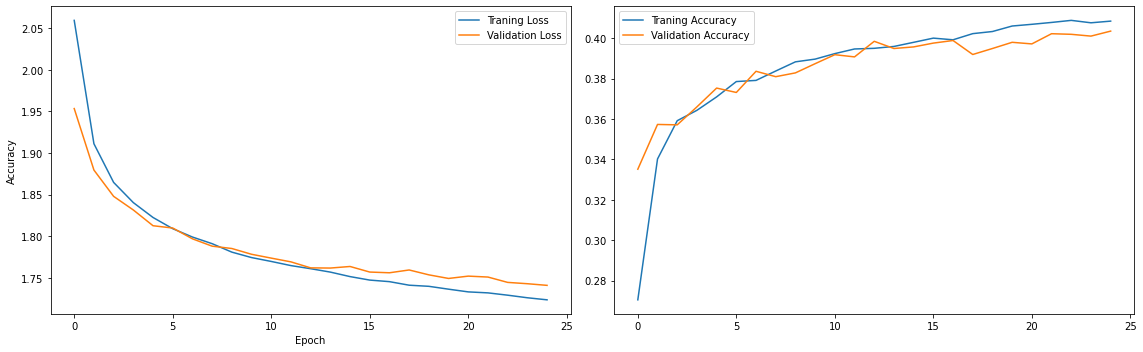

In [18]:
utils.plot_learning_curve(training_loss_hist2, valid_loss_hist2, training_acc_hist2, valid_acc_hist2)

test_loss, test_acc, confusion_matrix2 = utils.evaluate(model, test_loader, loss_function, device=device)
print("Test Loss : {} Test Acc: {}".format(test_loss, test_acc))

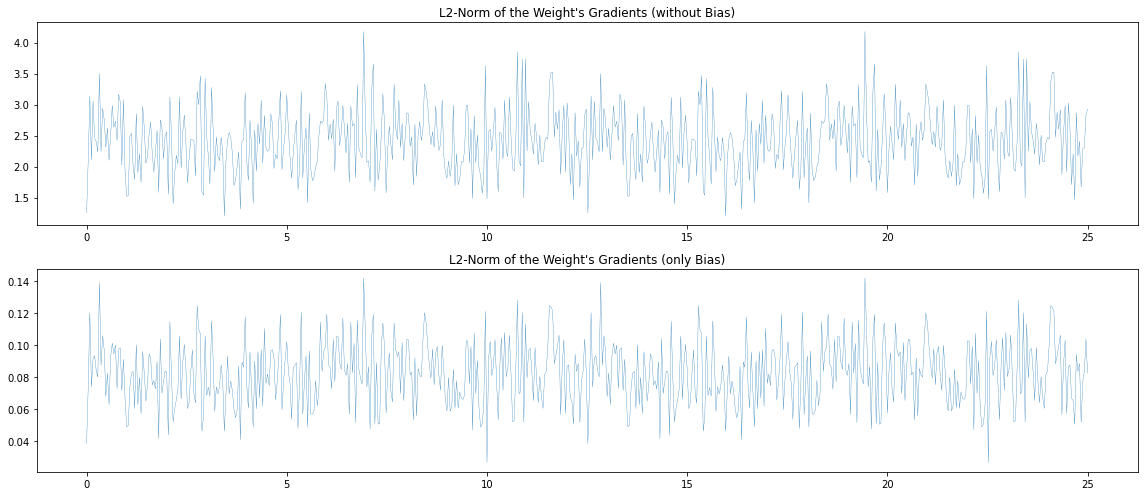

In [19]:
utils.plot_gradient_norms(weight_grad_norm_hist2, bias_grad_norm_hist2, max_epoch)

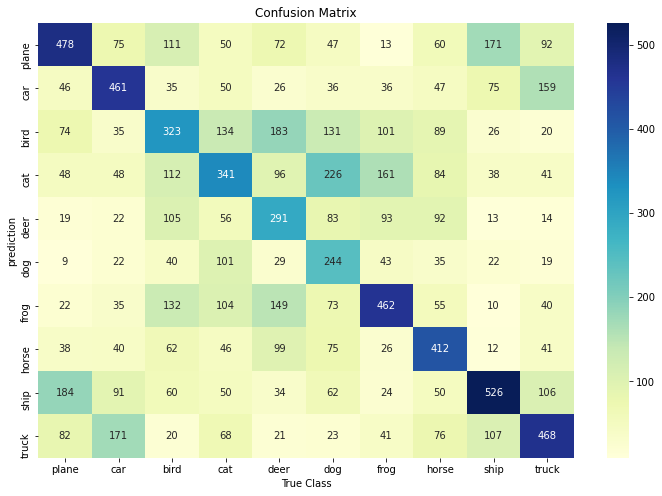

In [20]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
utils.plot_confusion_matrix(confusion_matrix2, classes)

## Compare Training 1 & Training 2

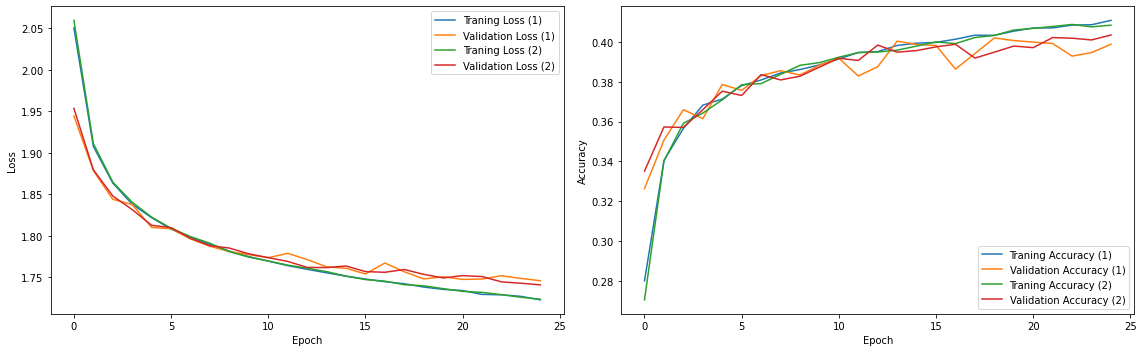

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))

ax1.plot(training_loss_hist1, label="Traning Loss (1)")
ax1.plot(valid_loss_hist1, label="Validation Loss (1)")
ax1.plot(training_loss_hist2, label="Traning Loss (2)")
ax1.plot(valid_loss_hist2, label="Validation Loss (2)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(training_acc_hist1, label="Traning Accuracy (1)")
ax2.plot(valid_acc_hist1, label="Validation Accuracy (1)")
ax2.plot(training_acc_hist2, label="Traning Accuracy (2)")
ax2.plot(valid_acc_hist2, label="Validation Accuracy (2)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

fig.tight_layout()

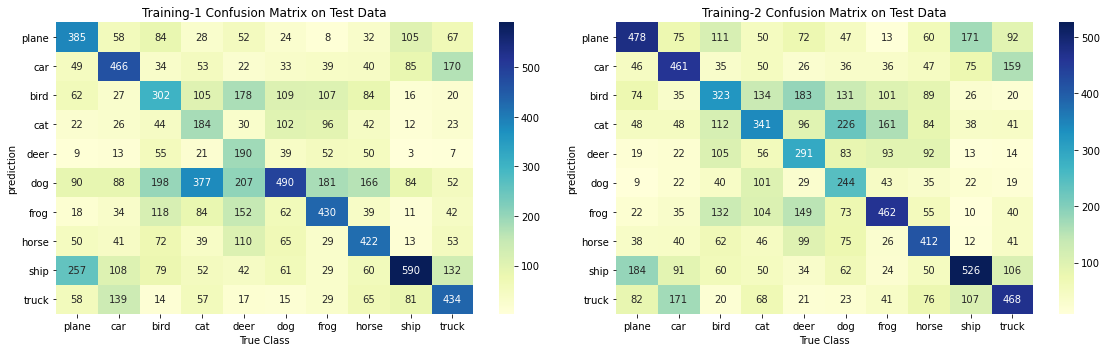

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

sns.heatmap(confusion_matrix1, annot=True, cmap="YlGnBu", fmt="g", ax=ax1, xticklabels=CLASSES, yticklabels=CLASSES)
ax1.set_xlabel("True Class")
ax1.set_ylabel("prediction")
ax1.set_title("Training-1 Confusion Matrix on Test Data")

sns.heatmap(confusion_matrix2, annot=True, cmap="YlGnBu", fmt="g", ax=ax2, xticklabels=CLASSES, yticklabels=CLASSES)
ax2.set_xlabel("True Class")
ax2.set_ylabel("prediction")
ax2.set_title("Training-2 Confusion Matrix on Test Data")

fig.tight_layout()

## Hyper-Parameter Tuning

In [35]:
max_epoch=25

In [61]:
# Train and Evaluate the Model Here
model = LogisticRegression(32*32*3, 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loader = DataLoader(trainset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
loss_function = nn.CrossEntropyLoss()

def objective(trial):
    # Using uniform distribution is not the most effective way for some hyperparameter like learning rate
    # Changing the learning rate logaritmically may affect the result linearly
    # See: https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-9, 1e-0) 
    batch_size = trial.suggest_int('batch_size', low=2, high=256, step=2)
    
    #training
    for epoch in range(max_epoch):
        utils.train_one_epoch(model, train_loader, optimizer, loss_function, device=device, debug=False)
        
    #evaluation
    valid_loss, valid_acc, _ = utils.evaluate(model, val_loader, loss_function, device=device)
    
    pbar.update(1)
    
    return valid_acc

In [49]:
def plot_hyperparameter_search_space(study, title=""):    
    # Parse hyper parameters from study trials
    x = []
    y = []
    values = []
    for t in study.get_trials():
        #print("params:", t.params, "values:", t.values)
        x.append(t.params["learning_rate"])
        y.append(t.params["batch_size"])
        values.append(t.values[0])

    # Plot all trials and plot approximated hyperparameters/performance space
    # Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html
    # Note about the visualization: x axis is normally log-scaled but tricontourf's are linearly connected.It is because we believe that when x axis changed in log scale model performance changes linearly
    fig, ax = plt.subplots(figsize=(16,6))
    ax.use_sticky_edges = False
    ax.plot(np.log10(x), y, 'k.')
    cntrf = ax.tricontourf(np.log10(x), y, values, levels=20)
    fig.colorbar(cntrf, ax=ax, label="Validation Accuracy")
    ax.set_title(title)
    ax.set_xlabel("$log_{10}$(learning_rate)")
    ax.set_ylabel("batch_size")

100%|███████████████████████████████████████| 100/100 [1:25:45<00:00, 51.46s/it]


Best hyperparameter is: {'learning_rate': 9.389077485335715e-05, 'batch_size': 40}
with 0.4125791139240506 accuracy


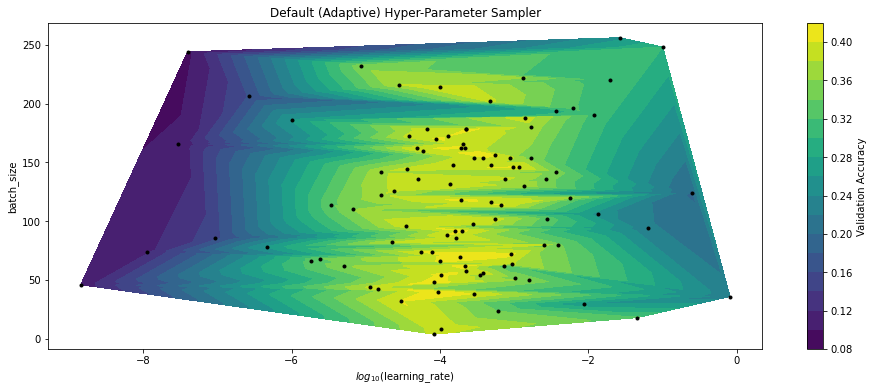

In [50]:
# Default (Adaptive) Sampler
LOAD_RESULTS_FROM_FILE=False
if LOAD_RESULTS_FROM_FILE:
    study = pickle.load( open( "adaptive_sampling.p", "rb" ) )
else:
    study = optuna.create_study(direction="maximize")
    with tqdm(total=100) as pbar:
        study.optimize(objective, n_trials=100)
    pickle.dump(study, open( "adaptive_sampling.p", "wb" ) )

plot_hyperparameter_search_space(study, title="Default (Adaptive) Hyper-Parameter Sampler")
print("Best hyperparameter is:", study.best_params)
print("with", study.best_value, "accuracy")

100%|███████████████████████████████████████| 100/100 [1:39:03<00:00, 59.44s/it]


Best hyperparameter is: {'learning_rate': 0.00011897818847630193, 'batch_size': 224}
with 0.4080300632911392 accuracy


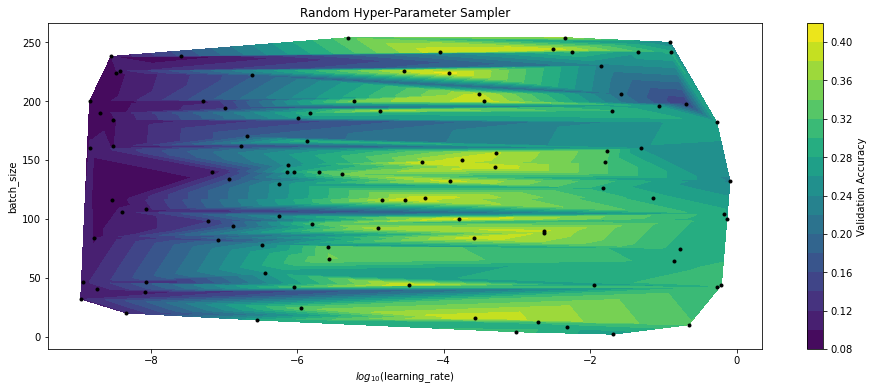

In [51]:
# Random Sampler
LOAD_RESULTS_FROM_FILE=False
if LOAD_RESULTS_FROM_FILE:
    study = pickle.load( open( "random_sampling.p", "rb" ) )
else:
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler())
    with tqdm(total=100) as pbar:
        study.optimize(objective, n_trials=100)
    pickle.dump(study, open( "random_sampling.p", "wb" ) )

plot_hyperparameter_search_space(study, title="Random Hyper-Parameter Sampler")
print("Best hyperparameter is:", study.best_params)
print("with", study.best_value, "accuracy")

100%|███████████████████████████████████████| 100/100 [1:10:14<00:00, 42.15s/it]


Best hyperparameter is: {'learning_rate': 1.0, 'batch_size': 202}
with 0.4131724683544304 accuracy


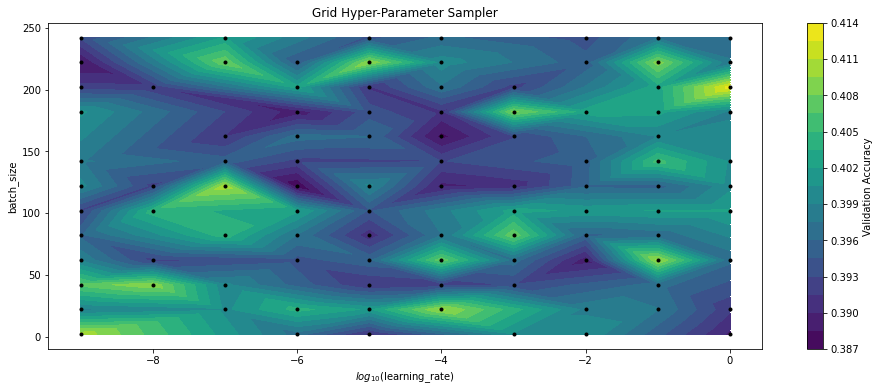

In [62]:
# Grid Sampler
LOAD_RESULTS_FROM_FILE=False
if LOAD_RESULTS_FROM_FILE:
    study = pickle.load( open( "grid_sampling.p", "rb" ) )
else:
    search_space = {"learning_rate": np.logspace(-9, 0, 10), 
                    "batch_size": (2*np.arange(1, 128, 10)).tolist()}
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.GridSampler(search_space))
    with tqdm(total=100) as pbar:
        study.optimize(objective, n_trials=100)
    pickle.dump(study, open( "grid_sampling.p", "wb" ) )

plot_hyperparameter_search_space(study, title="Grid Hyper-Parameter Sampler")
print("Best hyperparameter is:", study.best_params)
print("with", study.best_value, "accuracy")